Evaluating Sequences: 100%|██████████| 5/5 [47:03<00:00, 564.74s/it]


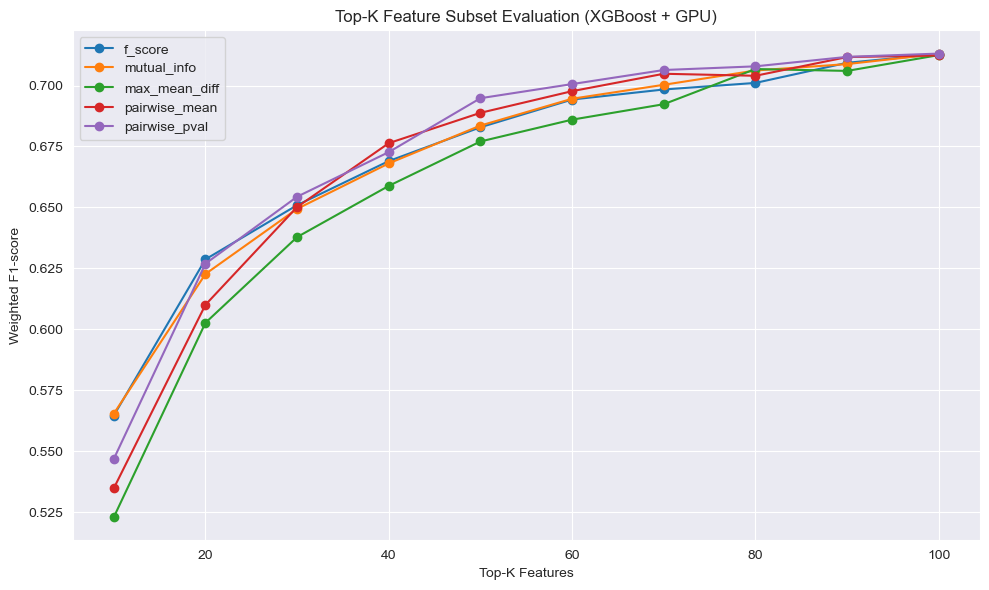


Best Top-K per feature sequence:
f_score              -> Top-100, Weighted F1 = 0.7129
mutual_info          -> Top-100, Weighted F1 = 0.7130
max_mean_diff        -> Top-100, Weighted F1 = 0.7125
pairwise_mean        -> Top-100, Weighted F1 = 0.7123
pairwise_pval        -> Top-100, Weighted F1 = 0.7131


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# === Step 1: 加载数据 ===
X = pd.read_csv("../data/X_train.csv", skiprows=1, header=None).values
y = pd.read_csv("../data/y_train.csv", skiprows=1, header=None).values.ravel()

# 标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)

# === Step 2: 加载特征序列 ===
def load_feature_indices(filepath, column="feature_idx"):
    return pd.read_csv(filepath)[column].astype(int).tolist()

feature_rankings = {
    "f_score": load_feature_indices("../output/f_score_with_p_value.csv"),
    "mutual_info": load_feature_indices("../output/mutual_info_global.csv"),
    "max_mean_diff": load_feature_indices("../output/max_class_mean_diff.csv"),
    "pairwise_mean": load_feature_indices("../output/pairwise_mean_diff_top_10_features.csv"),
    "pairwise_pval": load_feature_indices("../output/pairwise_p_value_top_10_features.csv")
}

# === Step 3: 手动实现 CV + XGBoost GPU 训练 ===
def evaluate_topk_f1_gpu_manualcv(X, y, feature_rankings, k_list=None, cv=5):
    if k_list is None:
        k_list = list(range(10, 101, 10))

    results = {}
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    for name, ranking in tqdm(feature_rankings.items(), desc="Evaluating Sequences"):
        scores = []

        for k in tqdm(k_list, desc=f"{name} Top-K", leave=False):
            selected_features = ranking[:k]
            X_k = X[:, selected_features]
            f1_scores = []

            for train_idx, val_idx in skf.split(X_k, y):
                X_train_cv, X_val_cv = X_k[train_idx], X_k[val_idx]
                y_train_cv, y_val_cv = y[train_idx], y[val_idx]

                model = XGBClassifier(
                    objective="multi:softprob",
                    num_class=28,
                    eval_metric="mlogloss",
                    use_label_encoder=False,
                    random_state=42,
                    tree_method="gpu_hist",
                    predictor="gpu_predictor",
                    verbosity=0
                )

                model.fit(X_train_cv, y_train_cv)
                y_pred = model.predict(X_val_cv)
                f1 = f1_score(y_val_cv, y_pred, average="weighted", zero_division=0)
                f1_scores.append(f1)

            scores.append((k, np.mean(f1_scores)))
        results[name] = scores
    return results

# === Step 4: 绘图函数 ===
def plot_topk_f1_curves(results):
    plt.figure(figsize=(10, 6))
    for name, score_list in results.items():
        k_vals, f1_vals = zip(*score_list)
        plt.plot(k_vals, f1_vals, marker='o', label=name)

    plt.xlabel("Top-K Features")
    plt.ylabel("Weighted F1-score")
    plt.title("Top-K Feature Subset Evaluation (XGBoost + GPU)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Step 5: 执行评估并绘图 ===
k_values = list(range(10, 101, 10))
results = evaluate_topk_f1_gpu_manualcv(X, y, feature_rankings, k_list=k_values)
plot_topk_f1_curves(results)

# === Step 6: 输出每组排序的最佳 top-k 与 F1-score ===
best = {name: max(score_list, key=lambda x: x[1]) for name, score_list in results.items()}
print("\nBest Top-K per feature sequence:")
for name, (k, score) in best.items():
    print(f"{name:20s} -> Top-{k:3d}, Weighted F1 = {score:.4f}")

In [14]:
from xgboost import XGBClassifier

model = XGBClassifier(tree_method="gpu_hist", predictor="gpu_predictor")
model.fit(X, y)

# 获取底层 Booster
booster = model.get_booster()

# 获取 booster 参数
print(booster.attributes())  # 返回 booster 的元信息
print(booster.save_config())  # 返回完整 JSON 配置（推荐）


{}
{"learner":{"generic_param":{"device":"cuda:0","fail_on_invalid_gpu_id":"0","n_jobs":"0","nthread":"0","random_state":"0","seed":"0","seed_per_iteration":"0","validate_parameters":"1"},"gradient_booster":{"gbtree_model_param":{"num_parallel_tree":"1","num_trees":"2800"},"gbtree_train_param":{"process_type":"default","tree_method":"gpu_hist","updater":"grow_gpu_hist","updater_seq":"grow_gpu_hist"},"name":"gbtree","specified_updater":false,"tree_train_param":{"alpha":"0","cache_opt":"1","colsample_bylevel":"1","colsample_bynode":"1","colsample_bytree":"1","eta":"0.300000012","gamma":"0","grow_policy":"depthwise","interaction_constraints":"","lambda":"1","learning_rate":"0.300000012","max_bin":"256","max_cat_threshold":"64","max_cat_to_onehot":"4","max_delta_step":"0","max_depth":"6","max_leaves":"0","min_child_weight":"1","min_split_loss":"0","monotone_constraints":"()","refresh_leaf":"1","reg_alpha":"0","reg_lambda":"1","sampling_method":"uniform","sketch_ratio":"2","sparse_threshold